This notebook presents how to fit log Gaussian tuning curves to the data from the NSDsyn dataset. In this example, the data is first binned by eccentricity (0.5-1, 1-2, & 2-4 deg) and then averaged across stimulus classes. The tuning curves are fitted for each eccentricity bin. 

Related snakemake rules: `binning`, `fit_tuning_curves`

# Configurations

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures/sfp_model/results_1D/nsdsyn')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'

In [3]:
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
roi_list=['V1','V2','V3']
lr = 0.005
max_epoch = 8000
subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
subj='subj02'
roi='V2'
voxels='pRFcenter'
stim_class='forward-spiral'

# Eccentricity bin information

In [5]:
e1, e2=0.5, 4
enum=7
enum_range=range(7) if enum==7 else range(3) 
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)
ecc_colors = utils.get_continuous_colors(len(bin_labels)+1, '#3f0377')
ecc_colors = ecc_colors[1:][::-1]
ecc_colors = dict(zip(bin_labels, ecc_colors))

# Load betas and experimental design information

In [7]:
subj_df = pd.read_csv(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'model', f'dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.csv'))
subj_df = subj_df.query('~names.str.contains("intermediate").values')


# 1. Binning

In [8]:
subj_df['ecc_bin'] = tuning.bin_ecc(subj_df['eccentricity'], bin_list, bin_labels)
bin_df = tuning.summary_stat_for_ecc_bin(subj_df,
                                       to_group=['sub','vroinames','ecc_bin','freq_lvl','names'],
                                       to_bin=['betas', 'local_sf'],
                                       central_tendency='mean')

## Sanity check: Datapoints only

In [95]:
tmp_bin_df = bin_df.query('sub == "subj02" & vroinames == "V2"')

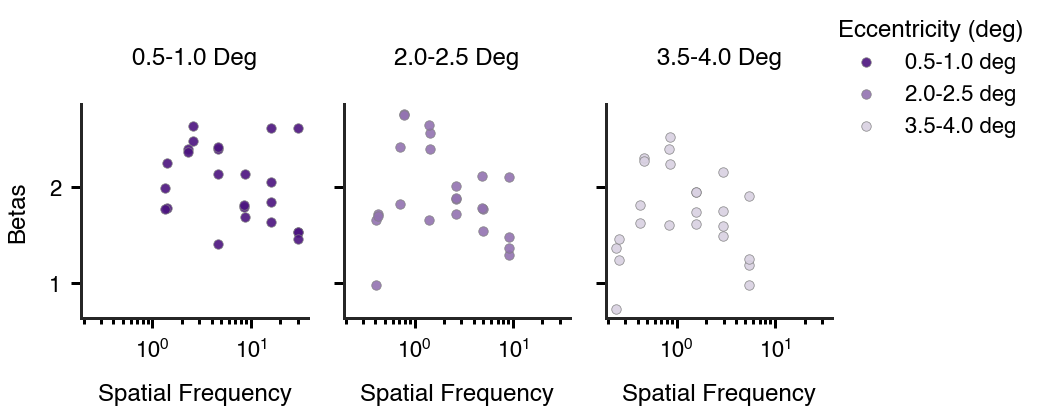

In [96]:
bins_to_plot = [bin_labels[k] for k in [0,3,-1]] 
vis1D.plot_datapoints(tmp_bin_df.query('ecc_bin in @bins_to_plot'), 
                      'local_sf', 'betas', hue='ecc_bin', hue_order=bins_to_plot, 
                      col='ecc_bin', col_order=bins_to_plot, 
                    height=6, aspect=0.7, lgd_title='Eccentricity (deg)',
                    palette=[ecc_colors[k] for k in bins_to_plot])

# 2. Fitting log Gaussian curves for every eccentricity bin

In [68]:
avg_bin_df = bin_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()


In [9]:
loss_history, model_history = pd.DataFrame({}), pd.DataFrame({})
for ecc_bin in avg_bin_df.ecc_bin.unique():
    print(f'{ecc_bin}')
    tmp = avg_bin_df.query('ecc_bin == @ecc_bin')
    my_model = tuning.LogGaussianTuningModel()
    my_dataset = tuning.LogGaussianTuningDataset(tmp['local_sf'], tmp['betas'])
    tmp_loss_history, tmp_model_history = tuning.fit_tuning_curves(my_model, my_dataset, 
                                                                   max_epoch=100, print_every=50, 
                                                                   learning_rate=0.01)
    tmp_model_history['ecc_bin'] = ecc_bin
    tmp_loss_history['ecc_bin'] = ecc_bin
    model_history = pd.concat((model_history, tmp_model_history), axis=0)
    loss_history = pd.concat((loss_history, tmp_loss_history), axis=0)


0.5-1.0 deg
**epoch no.0 loss: 3.88222
**epoch no.49 loss: 2.59849
**epoch no.99 loss: 1.15669
**epoch no.100: Finished! final params {'slope': 2.076, 'mode': 1.692, 'sigma': 1.587}
Elapsed time: 0.07 sec 

1.0-2.0 deg
**epoch no.0 loss: 5.89247
**epoch no.49 loss: 4.49853
**epoch no.99 loss: 2.53081
**epoch no.100: Finished! final params {'slope': 1.18, 'mode': 2.434, 'sigma': 1.775}
Elapsed time: 0.05 sec 

2.0-4.0 deg
**epoch no.0 loss: 6.61654
**epoch no.49 loss: 4.48473
**epoch no.99 loss: 2.4692
**epoch no.100: Finished! final params {'slope': 1.529, 'mode': 1.371, 'sigma': 1.991}
Elapsed time: 0.05 sec 


# 3. Plotting the results

## 3.1. loss and model history checks 

In [82]:
args = ['class', 'lr', 'eph', 'dset', 'sub', 'roi', 'curbin']
l, m = [], []
for curbin, subj in itertools.product(enum_range, subj_list):
    loss_file_name = f'loss-history_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.h5'
    model_file_name =f'model-history_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.h5'
    l.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', loss_file_name))
    m.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', model_file_name))


In [83]:
loss_df = utils.load_dataframes(l, *args)
model_df = utils.load_dataframes(m, *args)

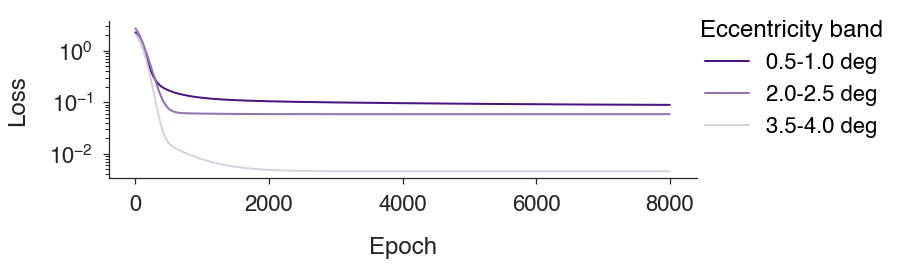

In [86]:
sub_tmp = ['subj01','subj02','subj03','subj04']
tmp_loss_df = loss_df.query('sub == "subj02" & ecc_bin in @bins_to_plot')
vis.plot_loss_history(tmp_loss_df[tmp_loss_df['epoch'] % 3 != 0], palette=[ecc_colors[k] for k in bins_to_plot], 
                      hue='ecc_bin', lgd_title='Eccentricity band', errorbar='se', log_y=True)

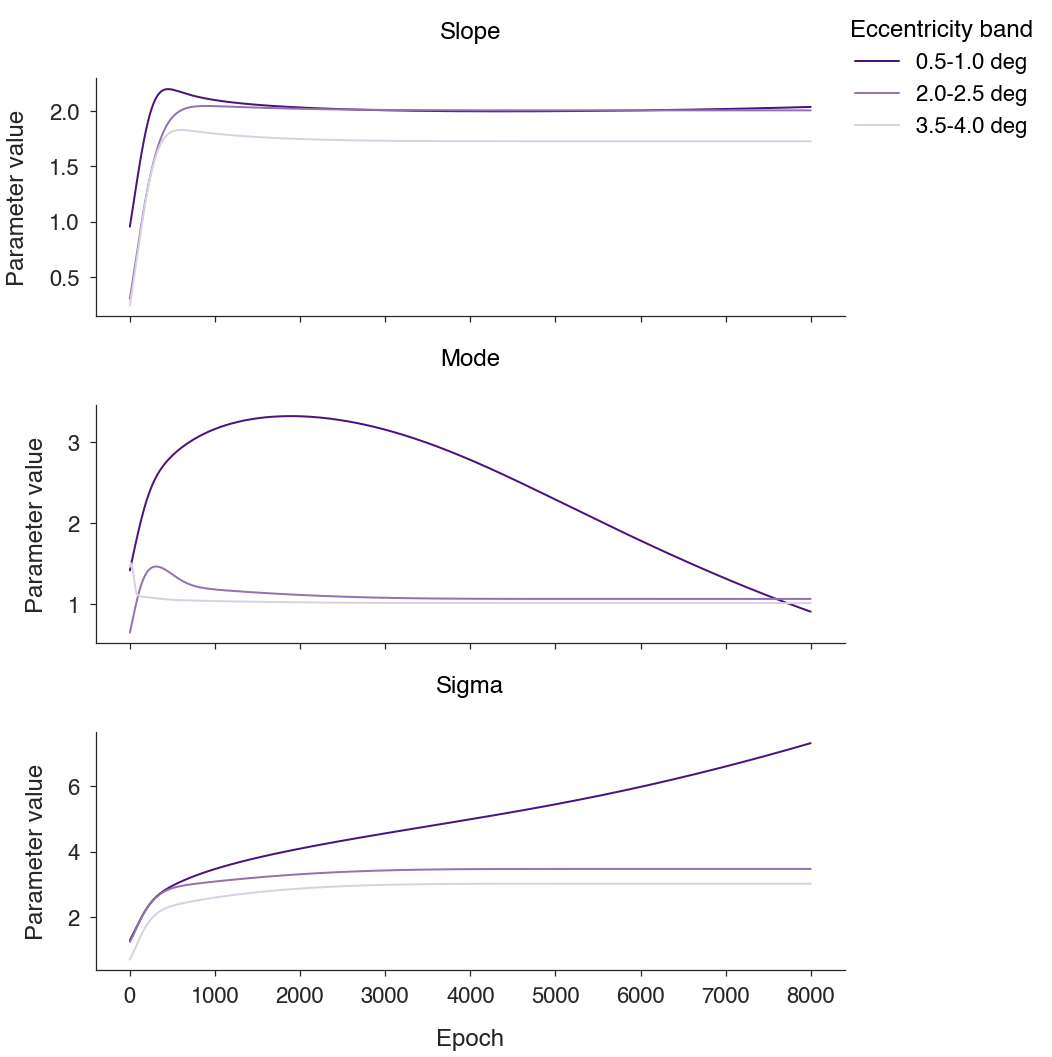

In [87]:
tmp_model_df = model_df.query('sub == "subj02" & ecc_bin in @bins_to_plot')
vis.plot_param_history(tmp_model_df[tmp_model_df['epoch'] % 3 != 0], 
                       params=['slope','mode','sigma'], palette=[ecc_colors[k] for k in bins_to_plot], 
                       hue='ecc_bin', lgd_title='Eccentricity band', errorbar='se')

## 3.2 Tuning curves

### Load the data and the model

In [9]:
f, m = [], []
for subj, roi in itertools.product(subj_list, roi_list):
    file_name = f'e1-{e1}_e2-{e2}_nbin-{enum}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'binned', file_name))

subj_df = utils.load_dataframes(f)
subj_df = subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']

pt_file_list = []
for subj, roi, curbin in itertools.product(subj_list, roi_list, enum_range):
    file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

In [22]:
tuning_df.query('names == @stim_class & sub == "subj02" & vroinames == "V2"')

,slope,mode,sigma,sub,names,dset,lr_rate,max_epoch,vroinames,e1,e2,nbin,curbin,ecc_bin
0,2.035757,0.911736,7.319947,subj02,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,7,0,0.5-1.0 deg
0,2.493156,0.015995,9.252839,subj02,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,7,1,1.0-1.5 deg
0,1.816084,0.185289,7.744349,subj02,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,7,2,1.5-2.0 deg
0,2.004641,1.068685,3.467788,subj02,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,7,3,2.0-2.5 deg
0,2.066149,1.076105,3.116098,subj02,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,7,4,2.5-3.0 deg
0,2.179414,1.057804,2.492667,subj02,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,7,5,3.0-3.5 deg
0,1.725598,1.016597,3.015003,subj02,forward spiral,nsdsyn,0.005,8000,V2,0.5,4,7,6,3.5-4.0 deg


In [431]:
tuning_with_precision_df = tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
fit_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'mode', 'precision', groupby=['vroinames','names'])

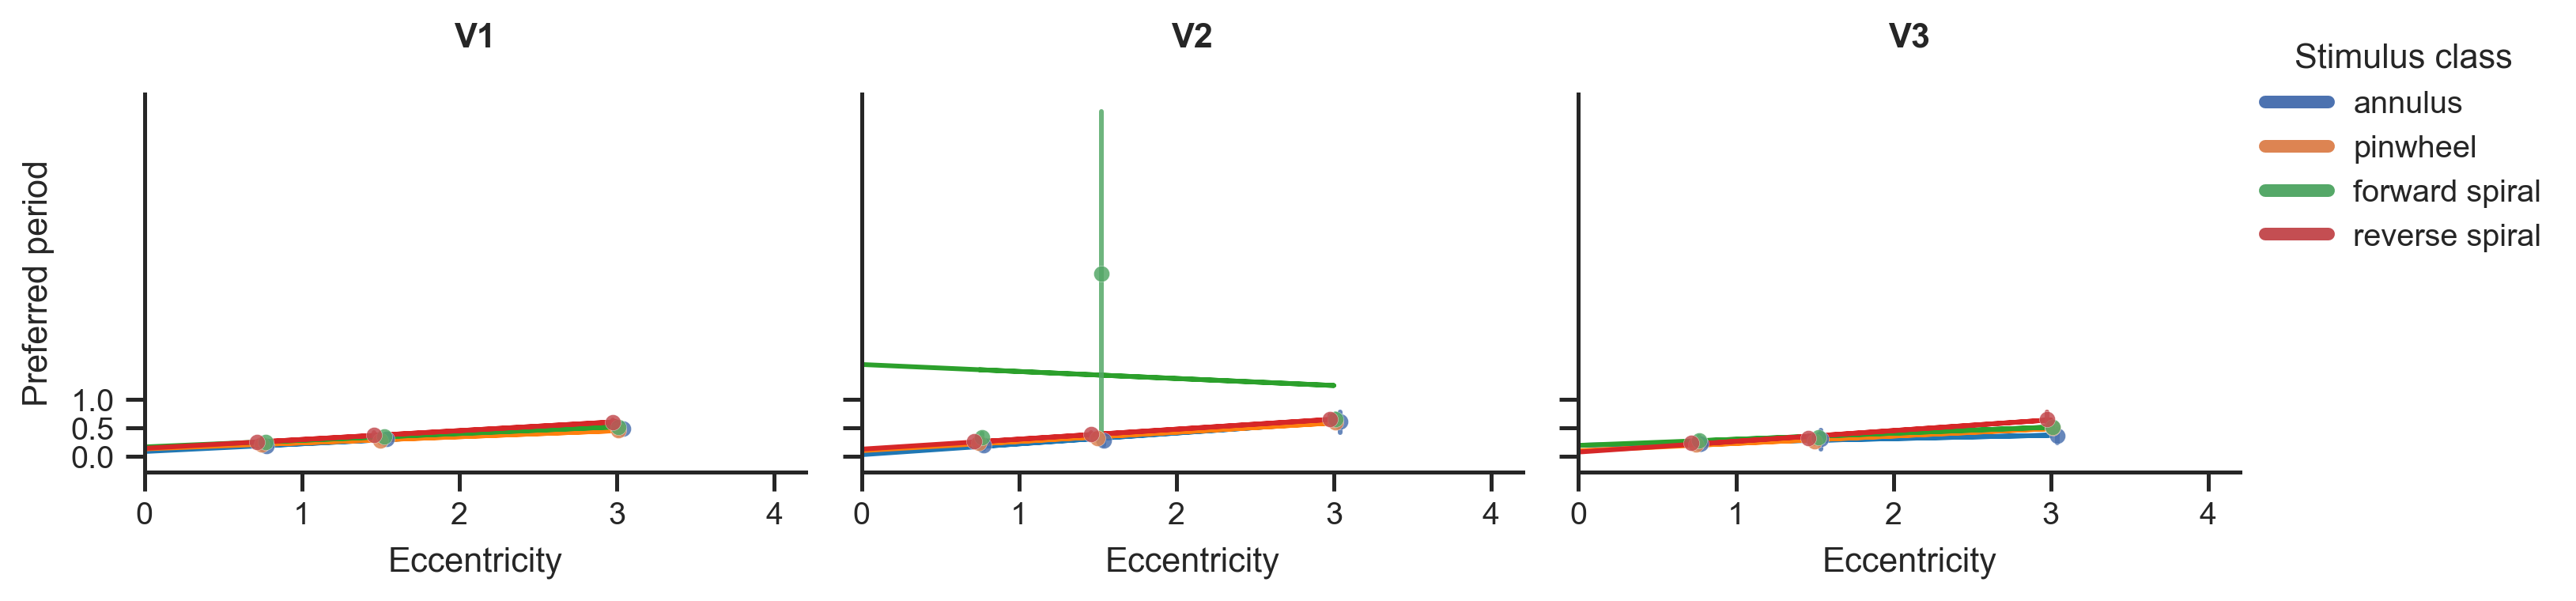

In [432]:
g = vis1D.plot_preferred_period(tuning_with_precision_df, col='vroinames', col_order=roi_list,
                                sf_peak='mode', precision='precision', hue='names', width=7,
                                hue_order=stim_classes, fit_df=fit_df, lgd_title='Stimulus class')